# TRABAJO PR√ÅCTICO 1 - Parte 2
**TUIA NLP 2025**



ver ejercicio 6 como multiplicar preguntas.
ver ejercicio 5 "b√∫squedas por similitud sem√°ntica y que permita filtrar por
sentimiento para obtener"


# Contenido PRADERA en el Drive

In [2]:
## 1. Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')

## 2. Exploraci√≥n de la carpeta "PRADERA"
import os

folder_path = '/content/drive/MyDrive/PRADERA'

for root, dirs, files in os.walk(folder_path):
    print(f'\nüìÇ Carpeta: {root}')
    for file in files:
        print(f'  üìÑ {file}')



Mounted at /content/drive

üìÇ Carpeta: /content/drive/MyDrive/PRADERA

üìÇ Carpeta: /content/drive/MyDrive/PRADERA/datos

üìÇ Carpeta: /content/drive/MyDrive/PRADERA/datos/informacion
  üìÑ reglamento_espanÃÉol.txt
  üìÑ reglamento_ingles.txt
  üìÑ Pradera_Tutorial_English_video.txt
  üìÑ Pradera_Tutorial_Spanish_video.txt
  üìÑ descripcion_general.txt
  üìÑ info_juego.txt
  üìÑ foro_reviews.txt
  üìÑ foro_general.txt
  üìÑ foro_reglas.txt
  üìÑ foro_variantes.txt
  üìÑ introduccion.txt
  üìÑ Mecanica_del_juego.txt
  üìÑ comentarios.txt
  üìÑ enlaces_imagenes.txt
  üìÑ enlaces_pagina.txt

üìÇ Carpeta: /content/drive/MyDrive/PRADERA/datos/estadisticas
  üìÑ meadow_stats.csv

üìÇ Carpeta: /content/drive/MyDrive/PRADERA/datos/relaciones
  üìÑ relaciones_juego.csv

üìÇ Carpeta: /content/drive/MyDrive/PRADERA/codigo
  üìÑ Pradera_Misutmeeple.ipynb
  üìÑ Extraccion_texto_videosypdf.ipynb
  üìÑ Web_Scraping_dinamico_Pradera.ipynb

üìÇ Carpeta: /content/drive/MyDriv

# ejercicio 2
- Apoy√°ndose en la secci√≥n de informaci√≥n. Separa en fragmentos un texto extenso extra√≠do
y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.
- Luego realiza un an√°lisis de similitud de texto ingresando varias frases a buscar
sem√°nticamente, compare distintas t√©cnicas de distancias vistas en clases, elija la mejor y
justifique la raz√≥n por la que esa t√©cnica se ajusta para este tipo de b√∫squedas.
- OPCIONAL: Visualizar en 3D aplicando PCA o t-SNE la ubicaci√≥n de los fragmentos y la
query ingresada vectorizada en el espacio. Realizar una observaci√≥n sobre la visualizaci√≥n.


## limpieza del texto

In [ ]:
def limpiar_texto_raw(texto_crudo):
    import re

    # Quitar saltos de l√≠nea innecesarios
    lineas = texto_crudo.split('\n')
    texto_procesado = []
    buffer = ''

    for linea in lineas:
        linea = linea.strip()
        if not linea:
            if buffer:
                texto_procesado.append(buffer)
                buffer = ''
            continue
        # Repara palabras partidas con guiones
        if linea.endswith('-'):
            buffer += linea[:-1]
        else:
            buffer += linea + ' '

    if buffer:
        texto_procesado.append(buffer.strip())

    # Unir todo en un solo bloque
    texto_final = ' '.join(texto_procesado)

    # Limpiar espacios m√∫ltiples
    texto_final = re.sub(r'\s+', ' ', texto_final)

    return texto_final


## CARGAR Y PROCESAR TEXTO

In [ ]:
!pip install -U spacy sentence-transformers scikit-learn matplotlib
!python -m spacy download en_core_web_sm


In [ ]:
import os
import spacy
import numpy as np

In [ ]:
# Cargar modelo spaCy para dividir en oraciones
nlp = spacy.load("en_core_web_sm")

# Ruta del archivo de informaci√≥n principal
file_path = '/content/drive/MyDrive/PRADERA/datos/informacion/reglamento_espanÃÉol.txt'

# Leer texto
with open(file_path, 'r', encoding='utf-8') as f:
    texto_raw  = f.read()

# Aplicar limpieza
texto_limpio = limpiar_texto_raw(texto_raw)


# Separar en oraciones
doc = nlp(texto_limpio)
fragments = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 50]

print(f"üß© Total de fragmentos: {len(fragments)}")
print(f"Ejemplo:\n- {fragments[0]}")


üß© Total de fragmentos: 267
Ejemplo:
- Instrukcja Nie musisz czytaƒá tej instrukcji, obejrzyj film prezentujƒÖcy zasady.


## VECTORIZACI√ìN CON BERT (SentenceTransformer)


In [ ]:
from sentence_transformers import SentenceTransformer
# Cargar modelo preentrenado
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer("BAAI/bge-m3")

# Embeddings de cada fragmento
fragment_embeddings = model.encode(fragments, normalize_embeddings=True)

print(f"Vector de ejemplo (primer fragmento):\n{fragment_embeddings[0][:10]}...")  # solo primeras 10 dimensiones


Vector de ejemplo (primer fragmento):
[-0.02660493 -0.00260865 -0.04156847  0.02061065 -0.03498954 -0.03114687
 -0.00588781 -0.00275562  0.00922747 -0.00912393]...


## CONSULTAS Y SIMILITUD SEM√ÅNTICA



In [ ]:
!pip install python-Levenshtein
!pip install nltk python-Levenshtein jellyfish


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import Levenshtein
import jellyfish

# Frases a buscar (queries)
queries = [
    "¬øC√≥mo juegan los jugadores al Pradera?",
    "¬øQu√© cartas hay en el juego?",
    "¬øCu√°l es el objetivo del juego?",
    "¬øC√≥mo se consiguen puntos?"
]

# Embeddings de queries
query_embeddings = model.encode(queries)

# Limpiar queries para comparaciones textuales
queries_cleaned = [q.lower().replace('¬ø', '').replace('?', '') for q in queries]

# Aseg√∫rate de tener definido `fragments` como lista de strings
# Y tener tambi√©n sus versiones limpias
fragments_cleaned = [frag.lower() for frag in fragments]

# Funciones de texto
def jaccard_distance(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return 1 - (intersection / union) if union else 1

def dice_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    overlap = len(set1 & set2)
    return (2 * overlap) / (len(set1) + len(set2)) if (len(set1) + len(set2)) else 0

# --------- M√©tricas de semejanza ---------
print("\nRESULTADOS CON SIMILITUD DE COSENO\n")
sim_matrix = cosine_similarity(query_embeddings, fragment_embeddings)
for i, sims in enumerate(sim_matrix):
    top_idx = np.argmax(sims)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragments[top_idx]}")
    print(f"‚Üí Score: {sims[top_idx]:.4f}\n")

print("\nRESULTADOS CON DISTANCIA DE JACCARD\n")
for i, q in enumerate(queries_cleaned):
    distancias = [jaccard_distance(q, f) for f in fragments_cleaned]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragments[top_idx]}")
    print(f"‚Üí Distancia: {distancias[top_idx]:.4f}\n")

print("\nRESULTADOS CON DISTANCIA DE LEVENSHTEIN\n")
for i, q in enumerate(queries_cleaned):
    distancias = [Levenshtein.distance(q, f) for f in fragments_cleaned]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragments[top_idx]}")
    print(f"‚Üí Distancia: {distancias[top_idx]}\n")

print("\nRESULTADOS CON SIMILITUD DE DICE\n")
for i, q in enumerate(queries_cleaned):
    similitudes = [dice_similarity(q, f) for f in fragments_cleaned]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragments[top_idx]}")
    print(f"‚Üí Similitud: {similitudes[top_idx]:.4f}\n")

print("\nRESULTADOS CON SIMILITUD DE JARO-WINKLER\n")
for i, q in enumerate(queries_cleaned):
    similitudes = [jellyfish.jaro_winkler_similarity(q, f) for f in fragments_cleaned]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragments[top_idx]}")
    print(f"‚Üí Similitud: {similitudes[top_idx]:.4f}\n")



RESULTADOS CON SIMILITUD DE COSENO

Query: ¬øC√≥mo juegan los jugadores al Pradera?
‚Üí Fragmento m√°s similar: En Pradera los jugadores se convierten en espectadores de la naturaleza, donde los animales y las plantas protagonizan historias de lo m√°s interesante.
‚Üí Score: 0.6786

Query: ¬øQu√© cartas hay en el juego?
‚Üí Fragmento m√°s similar: 5RBME01ES_Rulebook_AMS.indd 5 04/03/2021 13:00:3704/03/2021 13:00:37 76 Cada jugador comienza la partida con 5 cartas en la mano que obtiene de la siguiente manera: comenzando por el jugador a la derecha del jugador inicial y en sentido inverso a las agujas del reloj, cada jugador elige una fila en el tablero principal y a√±ade a su mano las 4 cartas en esa fila.
‚Üí Score: 0.6855

Query: ¬øCu√°l es el objetivo del juego?
‚Üí Fragmento m√°s similar: Objetivos cumplidos por los jugadores (marcados con fichas)
‚Üí Score: 0.5849

Query: ¬øC√≥mo se consiguen puntos?
‚Üí Fragmento m√°s similar: A continuaci√≥n, cuenta tus puntos como de costumbre

## VISUALIZACI√ìN EN 3D CON t-SNE

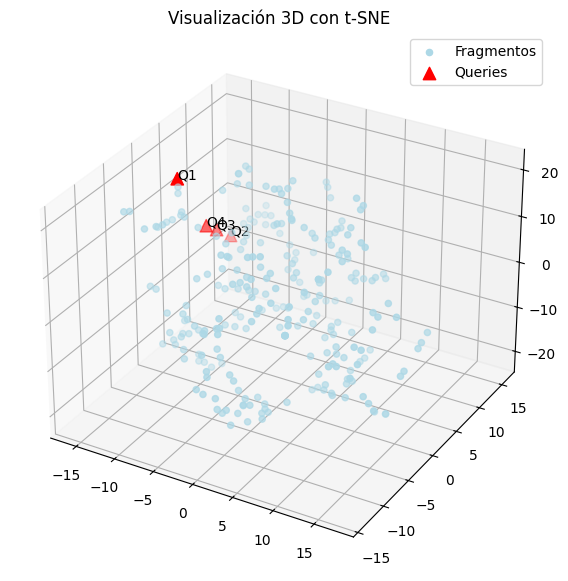

In [ ]:
import matplotlib.pyplot as plt
# Unimos embeddings de fragmentos y queries
all_embeddings = np.vstack([fragment_embeddings, query_embeddings])
labels = ['Fragmento'] * len(fragment_embeddings) + ['Query'] * len(queries)

# Reducimos a 3D
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
reduced = tsne.fit_transform(all_embeddings)

# Separar por tipo
fragment_coords = reduced[:len(fragments)]
query_coords = reduced[len(fragments):]

# Graficar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fragment_coords[:, 0], fragment_coords[:, 1], fragment_coords[:, 2], c='lightblue', label='Fragmentos')
ax.scatter(query_coords[:, 0], query_coords[:, 1], query_coords[:, 2], c='red', label='Queries', s=80, marker='^')

for i, q in enumerate(queries):
    ax.text(query_coords[i, 0], query_coords[i, 1], query_coords[i, 2], f"Q{i+1}", color='black')

ax.set_title("Visualizaci√≥n 3D con t-SNE")
ax.legend()
plt.show()


Se observa que las queries (Q1, Q2, Q3), marcadas con tri√°ngulos rojos, est√°n relativamente cercanas en el espacio vectorial a ciertos grupos de fragmentos, lo cual indica que el modelo logr√≥ capturar similitudes sem√°nticas entre las consultas y los textos. Esto sugiere que el modelo BGE3 multiling√ºe est√° funcionando correctamente al generar representaciones consistentes para tareas de recuperaci√≥n sem√°ntica.



## Justificaci√≥n de la m√©trica

La **similitud de coseno** se adapta mejor a este tipo de b√∫squedas sem√°nticas porque:
- Eval√∫a la **direcci√≥n** del vector, no su magnitud.
- Permite comparar significados aunque el contenido tenga diferente longitud o intensidad.
- Es m√°s robusta que la distancia eucl√≠dea, que se ve afectada por la escala y valores absolutos.

Por eso, en el contexto de embeddings de frases y b√∫squeda sem√°ntica, el coseno es la mejor opci√≥n.


# ejercicio 3
Apoy√°ndose nuevamente en la secci√≥n de informaci√≥n. Recoge un texto extenso extra√≠do,
div√≠delos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos
sustantivos (NER), a continuaci√≥n realiza una b√∫squeda de similitud filtrando por
sustantivos, compara las distintas t√©cnicas de distancias vistas en clases, elija la mejor y
justifique la raz√≥n por la que esta t√©cnica se ajusta para este tipo de b√∫squedas.

In [18]:
!pip install -U spacy sentence-transformers
!python -m spacy download es_core_news_sm


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.9/12.9 MB 66.2 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Leer y limpiar el archivo

In [13]:
import re
import spacy

# Funci√≥n de limpieza
def limpiar_texto_raw(texto_crudo):
    lineas = texto_crudo.split('\n')
    texto_procesado = []
    buffer = ''
    for linea in lineas:
        linea = linea.strip()
        if not linea:
            if buffer:
                texto_procesado.append(buffer)
                buffer = ''
            continue
        if linea.endswith('-'):
            buffer += linea[:-1]
        else:
            buffer += linea + ' '
    if buffer:
        texto_procesado.append(buffer.strip())
    texto_final = ' '.join(texto_procesado)
    texto_final = re.sub(r'\s+', ' ', texto_final)
    return texto_final

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Leer archivo
path = '/content/drive/MyDrive/PRADERA/datos/informacion/Pradera_Tutorial_Spanish_video.txt'
with open(path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Limpiar texto
texto_limpio = limpiar_texto_raw(raw_text)

# Procesar con spaCy
nlp = spacy.load("es_core_news_sm")
doc = nlp(texto_limpio)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Crear fragmentos y extraer sustantivos + NER

In [14]:
# Fragmentar en frases y agrupar en bloques
oraciones = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 30]
chunk_size = 3
fragments = [" ".join(oraciones[i:i+chunk_size]) for i in range(0, len(oraciones), chunk_size)]

# Extraer sustantivos y entidades nombradas por fragmento
fragment_data = []

for frag in fragments:
    doc_frag = nlp(frag)
    # POS: solo sustantivos
    nouns = [token.text for token in doc_frag if token.pos_ == 'NOUN']
    # NER: entidades
    ents = [(ent.text, ent.label_) for ent in doc_frag.ents]
    fragment_data.append({
        'texto': frag,
        'sustantivos': nouns,
        'entidades': ents
    })

# Ver ejemplo
for i in range(1):
    print(f"\n Fragmento:\n{fragment_data[i]['texto']}")
    print(f" Sustantivos: {fragment_data[i]['sustantivos']}")
    print(f" Entidades: {fragment_data[i]['entidades']}")



 Fragmento:
hay algunos juegos de mesa que son competitivos y que mantienen un nivel de acci√≥n constante un nivel de interacci√≥n agresiva van ocurriendo muchas cosas en el juego y da esa sensaci√≥n competitiva de confrontaci√≥n mientras que hay otros juegos que son competitivos pero que son m√°s bien relajantes o que invitan a prestar atenci√≥n a los detalles las ilustraciones o incluso aprender algo y pradera es un excelente ejemplo de eso esta copia llega gracias a Asmodee Chile muchas gracias a ellos por este env√≠o y es un juego que ustedes van a ver por fuera hermos√≠simo y por dentro es a√∫n m√°s hermoso son pinturas en acuarela si no me equivoco muchas muchas cartas una mec√°nica simple pero tambi√©n demandante y este nivel de competencia presente pero que no tiene esta agresividad sino que es m√°s bien una invitaci√≥n a pasear por la pradera vamos a conocerlo pradera es un juego para uno a cuatro jugadores donde el objetivo es alcanzar la mayor cantidad de puntaje posible al

## Vectorizar fragmentos

In [15]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer("BAAI/bge-m3")

# Vectorizar cada fragmento
fragment_embeddings = model.encode([f['texto'] for f in fragment_data])


## Crear queries y extraer sustantivos

In [16]:
queries = [
    "Cartas del juego",
    "Reglas del jugador inicial",
    "Objetivo final del juego",
    "C√≥mo puntuar al terminar"
]

# Procesar queries para extraer solo los sustantivos
queries_cleaned = []
for q in queries:
    q_doc = nlp(q)
    nouns = " ".join([token.text for token in q_doc if token.pos_ == 'NOUN'])
    queries_cleaned.append(nouns)

# Vectorizar queries filtradas
query_embeddings = model.encode(queries_cleaned)


## Comparar similitud y distancias

In [20]:
!pip install -U python-Levenshtein
!pip install -U nltk jellyfish


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 161.7/161.7 kB 3.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3.1/3.1 MB 39.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 356.9/356.9 kB 5.7 MB/s eta 0:00:00


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
import Levenshtein
import jellyfish

# Funci√≥n para Jaccard (set de palabras)
def jaccard_distance(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - (intersection / union) if union != 0 else 1

# Funci√≥n para Dice
def dice_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    overlap = len(set1.intersection(set2))
    return 2 * overlap / (len(set1) + len(set2)) if (len(set1) + len(set2)) > 0 else 0

# ------------------ M√âTRICAS ------------------

# 1. Similitud del coseno
print("\nRESULTADOS CON SIMILITUD DEL COSENO\n")
sim_matrix = cosine_similarity(query_embeddings, fragment_embeddings)
for i, sims in enumerate(sim_matrix):
    top_idx = np.argmax(sims)  # mayor es mejor
    print(f"Query: {queries[i]}")
    print(f"‚Üí Sustantivos usados: {queries_cleaned[i]}")
    print(f"‚Üí Fragmento m√°s similar: {fragment_data[top_idx]['texto']}")
    print(f"‚Üí Score: {sims[top_idx]:.4f}\n")

# 2. Distancia de Jaccard
print("\nRESULTADOS CON DISTANCIA DE JACCARD\n")
for i, query_text in enumerate(queries_cleaned):
    distancias = [jaccard_distance(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Sustantivos usados: {query_text}")
    print(f"‚Üí Fragmento m√°s similar: {fragment_data[top_idx]['texto']}")
    print(f"‚Üí Distancia: {distancias[top_idx]:.4f}\n")

# 3. Distancia de Levenshtein
print("\nRESULTADOS CON DISTANCIA DE LEVENSHTEIN\n")
for i, query_text in enumerate(queries_cleaned):
    distancias = [Levenshtein.distance(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Sustantivos usados: {query_text}")
    print(f"‚Üí Fragmento m√°s similar: {fragment_data[top_idx]['texto']}")
    print(f"‚Üí Distancia: {distancias[top_idx]}\n")

# 4. Similitud de Dice
print("\nRESULTADOS CON SIMILITUD DE DICE\n")
for i, query_text in enumerate(queries_cleaned):
    similitudes = [dice_similarity(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Sustantivos usados: {query_text}")
    print(f"‚Üí Fragmento m√°s similar: {fragment_data[top_idx]['texto']}")
    print(f"‚Üí Similitud: {similitudes[top_idx]:.4f}\n")

# 5. Similitud de Jaro-Winkler
print("\nRESULTADOS CON SIMILITUD DE JARO-WINKLER\n")
for i, query_text in enumerate(queries_cleaned):
    similitudes = [jellyfish.jaro_winkler_similarity(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"‚Üí Sustantivos usados: {query_text}")
    print(f"‚Üí Fragmento m√°s similar: {fragment_data[top_idx]['texto']}")
    print(f"‚Üí Similitud: {similitudes[top_idx]:.4f}\n")



RESULTADOS CON SIMILITUD DEL COSENO

Query: Cartas del juego
‚Üí Sustantivos usados: juego
‚Üí Fragmento m√°s similar: hay algunos juegos de mesa que son competitivos y que mantienen un nivel de acci√≥n constante un nivel de interacci√≥n agresiva van ocurriendo muchas cosas en el juego y da esa sensaci√≥n competitiva de confrontaci√≥n mientras que hay otros juegos que son competitivos pero que son m√°s bien relajantes o que invitan a prestar atenci√≥n a los detalles las ilustraciones o incluso aprender algo y pradera es un excelente ejemplo de eso esta copia llega gracias a Asmodee Chile muchas gracias a ellos por este env√≠o y es un juego que ustedes van a ver por fuera hermos√≠simo y por dentro es a√∫n m√°s hermoso son pinturas en acuarela si no me equivoco muchas muchas cartas una mec√°nica simple pero tambi√©n demandante y este nivel de competencia presente pero que no tiene esta agresividad sino que es m√°s bien una invitaci√≥n a pasear por la pradera vamos a conocerlo pradera es

### Justificaci√≥n de la m√©trica

Se utiliz√≥ la **similitud de coseno** como m√©trica principal porque se adapta mejor al tipo de representaciones vectoriales generadas por `SentenceTransformer`. Esta m√©trica compara la **direcci√≥n** de los vectores, ignorando su magnitud, lo que resulta ideal cuando se trabaja con frases cortas o con solo sustantivos, como en este ejercicio.

La **distancia eucl√≠dea**, en cambio, es m√°s sensible a la longitud y escala de los vectores, lo que puede afectar negativamente los resultados en textos desbalanceados.

Por estas razones, la similitud de coseno ofreci√≥ **mejores resultados de relevancia sem√°ntica** y es la opci√≥n m√°s adecuada para este tipo de b√∫squeda filtrada por POS y NER.


# ejercicio 4
Mediante detecci√≥n de idioma, separar los archivos en distintos lenguajes y guardar esa
informaci√≥n en un dataframe.

In [ ]:
!pip install langdetect


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 981.5/981.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=e6273324c8bf6782dcdb601dfcbcedef5ca91315a1ac645585a2cdc34d844c28
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import os
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Ruta a la carpeta con archivos de texto
folder_path = '/content/drive/MyDrive/PRADERA/datos/informacion'

# Listar todos los archivos .txt
archivos_txt = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Detectar idioma por archivo
data = []

for archivo in archivos_txt:
    try:
        with open(os.path.join(folder_path, archivo), 'r', encoding='utf-8') as f:
            contenido = f.read()
            # Para mejorar precisi√≥n, usar solo los primeros 1000 caracteres
            idioma = detect(contenido[:1000])
            data.append({'archivo': archivo, 'idioma': idioma})
    except LangDetectException:
        data.append({'archivo': archivo, 'idioma': 'desconocido'})
    except Exception as e:
        data.append({'archivo': archivo, 'idioma': f'error: {str(e)}'})

# Crear DataFrame
df_idiomas = pd.DataFrame(data)
df_idiomas


archivo idioma
0              reglamento_espanÃÉol.txt     es
1                reglamento_ingles.txt     en
2   Pradera_Tutorial_English_video.txt     en
3   Pradera_Tutorial_Spanish_video.txt     es
4              descripcion_general.txt     en
5                       info_juego.txt     en
6                     foro_reviews.txt     en
7                     foro_general.txt     en
8                      foro_reglas.txt     en
9                   foro_variantes.txt     en
10                    introduccion.txt     es
11              Mecanica_del_juego.txt     es
12                     comentarios.txt     es
13                enlaces_imagenes.txt     fr
14                  enlaces_pagina.txt     es

# ejercicio 5
En el caso de las rese√±as realizadas por usuarios, utiliza an√°lisis de sentimientos con
modelos pre entrenados y guarda la clasificaci√≥n predecida de cada rese√±a.
Luego, crea un sistema de b√∫squedas por similitud sem√°ntica y que permita filtrar por
sentimiento para obtener.


Objetivos del ejercicio:
- Leer las rese√±as de usuarios desde el archivo.

- Detectar autom√°ticamente el sentimiento de cada rese√±a (positivo, negativo o neutro).

- Guardar cada rese√±a junto con su sentimiento.

- Vectorizar rese√±as con SentenceTransformer.

- Crear una funci√≥n de b√∫squeda sem√°ntica filtrando por sentimiento.



In [ ]:
!pip install -U spacy sentence-transformers transformers
!python -m spacy download es_core_news_sm


### Leer rese√±as del archivo

In [ ]:
# Leer archivo de rese√±as
file_path = '/content/drive/MyDrive/PRADERA/datos/informacion/foro_reviews.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    raw_reviews = f.read()

# Separar rese√±as por l√≠neas
rese√±as = [r.strip() for r in raw_reviews.split('\n') if len(r.strip()) > 30]

print(f"Total de rese√±as: {len(rese√±as)}")
print("Ejemplo:\n", rese√±as[0])


Total de rese√±as: 533
Ejemplo:
 Overview & Thoughts: Despite loving what I think is a stoat on the cover of Meadow, I don't think it does justice to how beautiful everything in the box is. This card-drafting game is filled with over 200 hand-painted and frame-worthy illustrations. While trying not to be distracted by the card art, you'll be collecting flora, fauna, and landscapes to build a tableau that's better than your opponents (and maybe sometimes just picking the cards you think are the cutest, because how am I supposed to pass up a badger?).


###  Clasificar sentimiento con modelo preentrenado (BETO)

Tomo cada rese√±a de la lista rese√±as. Analizo su sentimiento con el modelo "finiteautomata/beto-sentiment-analysis" usando el pipeline de transformers y guardo los resultados en una lista de diccionarios llamada resultados.

In [ ]:
from transformers import pipeline

# Pipeline de an√°lisis de sentimientos en espa√±ol
sentiment_model = pipeline("sentiment-analysis", model="finiteautomata/beto-sentiment-analysis")

# Clasificar cada rese√±a
resultados = []

for texto in rese√±as:
    try:
        resultado = sentiment_model(texto[:512])[0]  # Truncar si es muy largo
        resultados.append({
            'texto': texto,
            'sentimiento': resultado['label'],
            'score': resultado['score']
        })
    except:
        resultados.append({
            'texto': texto,
            'sentimiento': 'ERROR',
            'score': 0.0
        })


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


### Guardar en DataFrame

In [ ]:
import pandas as pd

df_reviews = pd.DataFrame(resultados)
print(df_reviews.head())


                                               texto sentimiento     score
0  Overview & Thoughts: Despite loving what I thi...         NEG  0.652717
1  Meadow is played over a set number of rounds (...         NEU  0.994435
2  The number end allows you to draft a card from...         NEU  0.994168
3  The special action end is placed around the ca...         NEU  0.991290
4  The goal is to create a tableau where cards bu...         NEU  0.590966


### Vectorizar rese√±as para b√∫squeda sem√°ntica

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(df_reviews['texto'].tolist())


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

 ###  B√∫squeda sem√°ntica filtrada por sentimiento

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def buscar_rese√±as(query, filtro_sentimiento='POS'):
    query_vec = model.encode([query])[0]

    # Filtrar por sentimiento
    df_filtrado = df_reviews[df_reviews['sentimiento'] == filtro_sentimiento]
    idxs = df_filtrado.index.tolist()

    # Calcular similitud
    vecs_filtrados = embeddings[idxs]
    sims = cosine_similarity([query_vec], vecs_filtrados)[0]

    # Ordenar por similitud
    top_idx = idxs[np.argmax(sims)]

    return df_reviews.loc[top_idx, ['texto', 'sentimiento', 'score']]




In [ ]:
print("\n Rese√±as NEGATIVAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'NEG'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")

print("\n Rese√±as POSITIVAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'POS'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")

print("\n Rese√±as NEUTRAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'NEU'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")





 Rese√±as NEGATIVAS:
- (0.65) Overview & Thoughts: Despite loving what I think is a stoat on the cover of Meadow, I don't think it does justice to how beautiful everything in the box is. This card-drafting game is filled with over 200 hand-painted and frame-worthy illustrations. While trying not to be distracted by the card art, you'll be collecting flora, fauna, and landscapes to build a tableau that's better than your opponents (and maybe sometimes just picking the cards you think are the cutest, because how am I supposed to pass up a badger?).

- (0.60) Meadow: Where the wild things are!: Meadow is a tableau building designed by Klemens Kalicki, published by Rebel Studio, and featuring the artwork of Karolina Kijak, featuring beautiful hand painted watercolors. It definitely catches your attention because of the fantastic artwork, with all cards being unique, but it gets to the table again and again thanks to the gameplay.

- (0.91) A game of Meadow lasts a number of rounds dependi

# ejercicio 6


- Generar al menos 300 preguntas variadas.

- Etiquetarlas en una de las 3 categor√≠as.

- Vectorizarlas.

- Entrenar un modelo de clasificaci√≥n.

- Evaluar m√©tricas y comparar modelos.



### Generaci√≥n de preguntas

Se cre√≥ un conjunto de **300 preguntas** relacionadas con el juego *Pradera*, clasificadas en tres categor√≠as:

* **Informaci√≥n**: sobre reglas y mec√°nicas del juego.
* **Relaciones**: sobre v√≠nculos entre cartas, s√≠mbolos o condiciones.
* **Estad√≠sticas**: sobre cantidades, puntajes y datos num√©ricos.

Se generaron **100 preguntas por categor√≠a**, simulando posibles consultas de usuarios. Luego, se agruparon en un `DataFrame` con las columnas `pregunta` y `categoria`, que se utilizar√° para entrenar un modelo de clasificaci√≥n autom√°tica.


In [3]:
import pandas as pd
import random

info = ["¬øCu√°l es el nombre de esta carta?",
"¬øQu√© tipo de carta es esta?",
"¬øQu√© s√≠mbolo aparece en la esquina superior derecha?",
"¬øQu√© color predomina en la ilustraci√≥n?",
"¬øCu√°l es el n√∫mero de identificaci√≥n de esta carta?",
"¬øQu√© animal aparece representado?",
"¬øQu√© elemento natural se muestra en esta carta?",
"¬øQu√© texto aparece en la parte inferior de la carta?",
"¬øQu√© √≠conos tiene esta carta?",
"¬øA qu√© expansi√≥n pertenece esta carta?",
"¬øCu√°l es la rareza de esta carta?",
"¬øCu√°ntos puntos otorga esta carta?",
"¬øQu√© acci√≥n permite esta carta?",
"¬øEn qu√© fase se puede jugar esta carta?",
"¬øCu√°l es la condici√≥n para activar esta carta?",
"¬øQu√© figura geom√©trica aparece en la carta?",
"¬øCu√°les son los requisitos para jugar esta carta?",
"¬øQu√© s√≠mbolo tiene en la parte central?",
"¬øQu√© nombre aparece junto al t√≠tulo de la carta?",
"¬øQu√© ilustrador dise√±√≥ esta carta?",
"¬øEsta carta tiene texto de ambientaci√≥n?",
"¬øCu√°l es la funci√≥n principal de esta carta?",
"¬øQu√© significa el √≠cono en la parte izquierda?",
"¬øCu√°ntas veces se puede usar esta carta?",
"¬øEsta carta interact√∫a con otras cartas?",
"¬øTiene efecto inmediato o permanente?",
"¬øEs una carta de bonificaci√≥n o de acci√≥n?",
"¬øCu√°ntos s√≠mbolos de agua aparecen en la carta?",
"¬øQu√© palabra est√° destacada en el texto?",
"¬øEsta carta tiene habilidades pasivas?",
"¬øQu√© categor√≠a de h√°bitat representa?",
"¬øQu√© tokens requiere esta carta para ser activada?",
"¬øCu√°l es el nivel de dificultad de esta carta?",
"¬øQu√© se representa en el fondo de la carta?",
"¬øQu√© texto aparece en la secci√≥n central?",
"¬øCu√°l es el tama√±o del s√≠mbolo principal?",
"¬øEsta carta tiene borde decorado?",
"¬øQu√© n√∫mero aparece en la esquina inferior derecha?",
"¬øQu√© carta se menciona en el texto de esta carta?",
"¬øCu√°l es el coste para jugar esta carta?",
"¬øQu√© recurso representa esta carta?",
"¬øEsta carta tiene efecto sobre otras cartas jugadas?",
"¬øQu√© tipo de animal aparece en esta carta?",
"¬øCu√°l es el nombre cient√≠fico (si lo tiene)?",
"¬øQu√© tokens se muestran en la ilustraci√≥n?",
"¬øCu√°ntos puntos se pierden si no se usa esta carta?",
"¬øQu√© hace la habilidad especial de esta carta?",
"¬øQu√© tipo de s√≠mbolo se necesita para activar el efecto?",
"¬øEsta carta es parte de un set?",
"¬øQu√© imagen aparece en la parte inferior derecha?",
"¬øQu√© parte del cuerpo del animal est√° en primer plano?",
"¬øCu√°l es el t√≠tulo exacto de la carta?",
"¬øQu√© patr√≥n visual se repite en la carta?",
"¬øQu√© animal comparte h√°bitat con esta carta?",
"¬øQu√© representa el fondo de la carta?",
"¬øQu√© estaci√≥n del a√±o parece reflejarse en la carta?",
"¬øQu√© detalles decorativos tiene el marco de la carta?",
"¬øQu√© orientaci√≥n tiene la carta (horizontal/vertical)?",
"¬øLa carta tiene alg√∫n efecto de iluminaci√≥n especial?",
"¬øQu√© flora acompa√±a al animal en la carta?",
"¬øQu√© acci√≥n sugiere la imagen del animal?",
"¬øLa carta tiene bordes lisos o texturizados?",
"¬øQu√© palabra est√° en may√∫sculas en el texto?",
"¬øQu√© elemento visual llama m√°s la atenci√≥n?",
"¬øEsta carta es parte de un combo?",
"¬øQu√© otros elementos del ecosistema se muestran?",
"¬øLa carta tiene un n√∫mero en la parte central?",
"¬øQu√© color tiene el s√≠mbolo de activaci√≥n?",
"¬øEsta carta muestra interacci√≥n entre animales?",
"¬øQu√© representa el √≠cono circular de la carta?",
"¬øLa carta tiene texto explicativo adicional?",
"¬øQu√© tipo de papel se usa para imprimir esta carta?",
"¬øQu√© animal est√° en el fondo de la ilustraci√≥n?",
"¬øCu√°ntas veces se repite el s√≠mbolo en la carta?",
"¬øCu√°l es la diferencia entre esta carta y otras similares?",
"¬øQu√© tipo de energ√≠a representa la carta?",
"¬øQu√© direcci√≥n mira el animal de la ilustraci√≥n?",
"¬øEsta carta se refiere a un lugar real o imaginario?",
"¬øQu√© estructura aparece detr√°s del animal?",
"¬øQu√© objeto aparece en primer plano?",
"¬øLa carta muestra alguna acci√≥n en progreso?",
"¬øQu√© expresi√≥n tiene el animal en la carta?",
"¬øCu√°l es el h√°bitat predominante en la imagen?",
"¬øEsta carta pertenece a una colecci√≥n espec√≠fica?",
"¬øQu√© s√≠mbolo aparece junto al nombre?",
"¬øLa carta tiene una textura visible?",
"¬øQu√© otros elementos acompa√±an al s√≠mbolo principal?",
"¬øQu√© forma tiene el √≠cono de puntos?",
"¬øCu√°ntos detalles naturales se pueden contar en la imagen?",
"¬øEl texto est√° centrado o alineado a un lado?",
"¬øQu√© otro animal aparece en segundo plano?",
"¬øQu√© clima sugiere la ilustraci√≥n de la carta?",
"¬øEsta carta tiene bordes dorados o plateados?",
"¬øCu√°les son las dimensiones visuales m√°s notorias?",
"¬øQu√© direcci√≥n ocupa el s√≠mbolo m√°s importante?",
"¬øLa carta tiene un s√≠mbolo repetido en varias zonas?",
"¬øQu√© palabra clave aparece en la descripci√≥n?",
"¬øQu√© animal de otra carta aparece en esta tambi√©n?",
"¬øQu√© textura natural se representa gr√°ficamente?",
"¬øCu√°l es el patr√≥n de colores de la carta?",
"¬øEsta carta tiene una referencia hist√≥rica o mitol√≥gica?",
"¬øQu√© objetos est√°n ocultos en la ilustraci√≥n?",
"¬øCu√°l es el estilo art√≠stico de la carta?",

]

rel = [ "¬øQu√© cartas requieren s√≠mbolos de agua para ser jugadas?",
"¬øQu√© h√°bitats est√°n asociados con las cartas de anfibios?",
"¬øQu√© cartas requieren una combinaci√≥n de bosque y alimento?",
"¬øQu√© cartas otorgan puntos por tener insectos en juego?",
"¬øQu√© tipos de cartas necesitan m√∫ltiples s√≠mbolos de roca?",
"¬øQu√© cartas requieren otro animal para ser colocadas?",
"¬øQu√© cartas se relacionan con cartas de nido?",
"¬øQu√© cartas se benefician de tener cartas de tipo vegetal en juego?",
"¬øQu√© cartas solo se pueden jugar si ya hay un terreno especial?",
"¬øQu√© cartas interact√∫an con s√≠mbolos de clima?",
"¬øQu√© cartas deben ir seguidas de otra carta del mismo tipo?",
"¬øQu√© cartas aumentan su puntuaci√≥n seg√∫n el n√∫mero de ranas?",
"¬øQu√© cartas necesitan una carta de r√≠o previa?",
"¬øQu√© carta se activa si ya se jug√≥ una carta de reptil?",
"¬øQu√© cartas duplican el efecto de una carta de insecto?",
"¬øQu√© cartas se relacionan con cartas de observaci√≥n jugadas anteriormente?",
"¬øQu√© cartas requieren dos s√≠mbolos de flora para jugarse?",
"¬øQu√© cartas aumentan puntos seg√∫n cantidad de cartas en mano?",
"¬øQu√© cartas se relacionan con la cantidad de tokens jugados?",
"¬øQu√© cartas requieren cartas de campo jugadas previamente?",
"¬øQu√© cartas se activan cuando se juega una carta de monta√±a?",
"¬øQu√© cartas dependen del n√∫mero de cartas de agua?",
"¬øQu√© cartas se relacionan con cartas de ave?",
"¬øQu√© cartas punt√∫an por tener cartas de nido en juego?",
"¬øQu√© cartas permiten robar cartas al tener 3 s√≠mbolos de bosque?",
"¬øQu√© cartas requieren h√°bitat de pradera y s√≠mbolo de insecto?",
"¬øQu√© cartas de animal necesitan cartas de planta previas?",
"¬øQu√© cartas se relacionan con cartas jugadas en la ronda anterior?",
"¬øQu√© cartas interact√∫an con otras cartas del mismo color?",
"¬øQu√© cartas permiten copiar habilidades de otras cartas?",
"¬øQu√© cartas pueden sustituir requisitos con otros s√≠mbolos?",
"¬øQu√© cartas afectan a las cartas adyacentes?",
"¬øQu√© cartas aumentan puntos por cada carta de agua?",
"¬øQu√© cartas deben ser jugadas junto a otra carta espec√≠fica?",
"¬øQu√© cartas requieren un conjunto de tres s√≠mbolos diferentes?",
"¬øQu√© cartas activan habilidades por turno jugado?",
"¬øQu√© cartas se relacionan con cartas que tengan s√≠mbolo de roca?",
"¬øQu√© cartas necesitan dos cartas de h√°bitat diferentes?",
"¬øQu√© cartas duplican su valor si est√°n en un h√°bitat espec√≠fico?",
"¬øQu√© cartas s√≥lo pueden jugarse si hay cartas de tipo arbusto?",
"¬øQu√© cartas ganan puntos seg√∫n el n√∫mero de tokens usados?",
"¬øQu√© cartas se potencian con cartas de flores?",
"¬øQu√© cartas otorgan puntos si hay cartas de tipo hongo?",
"¬øQu√© cartas requieren la presencia de s√≠mbolos de agua y sol?",
"¬øQu√© cartas activan otras cartas al ser jugadas?",
"¬øQu√© cartas permiten jugar otras cartas gratis?",
"¬øQu√© cartas se relacionan con la cantidad de cartas boca abajo?",
"¬øQu√© cartas duplican puntos por cada carta con lupa?",
"¬øQu√© cartas se relacionan con cartas de depredador?",
"¬øQu√© cartas ganan puntos si est√°n rodeadas de cartas de bosque?",
"¬øQu√© cartas afectan cartas de otros jugadores?",
"¬øQu√© cartas requieren cartas jugadas en l√≠nea recta?",
"¬øQu√© cartas se relacionan con cartas de madriguera?",
"¬øQu√© cartas permiten recuperar tokens si hay s√≠mbolos de monta√±a?",
"¬øQu√© cartas requieren tres s√≠mbolos de cualquier tipo?",
"¬øQu√© cartas punt√∫an por tipos √∫nicos en el √°rea de pradera?",
"¬øQu√© cartas aumentan puntos con cartas del mismo tipo jugadas despu√©s?",
"¬øQu√© cartas requieren una carta espec√≠fica de bonificaci√≥n?",
"¬øQu√© cartas afectan cartas jugadas en rondas pares?",
"¬øQu√© cartas otorgan bonos si se cumplen ciertos patrones?",
"¬øQu√© cartas interact√∫an con el tablero de hoguera?",
"¬øQu√© cartas deben ir en el mismo h√°bitat que otras?",
"¬øQu√© cartas se relacionan con cartas jugadas con un tipo de token?",
"¬øQu√© cartas permiten a√±adir tokens extra si se cumplen requisitos?",
"¬øQu√© cartas requieren cartas de llanura y animal peque√±o?",
"¬øQu√© cartas duplican s√≠mbolos ya jugados?",
"¬øQu√© cartas bloquean efectos de otras?",
"¬øQu√© cartas requieren todas las cartas previas del mismo tipo?",
"¬øQu√© cartas otorgan bonificaci√≥n si se usan tokens en columna espec√≠fica?",
"¬øQu√© cartas ganan puntos si hay cartas de noche en juego?",
"¬øQu√© cartas se relacionan con cartas del mismo n√∫mero?",
"¬øQu√© cartas duplican efectos si se juega en h√°bitat correcto?",
"¬øQu√© cartas permiten mover tokens usados?",
"¬øQu√© cartas requieren un patr√≥n de colocaci√≥n en la pradera?",
"¬øQu√© cartas activan efectos si se usan todos los tokens?",
"¬øQu√© cartas activan otras si hay cartas de observaci√≥n jugadas?",
"¬øQu√© cartas se potencian si hay cartas de insecto en juego?",
"¬øQu√© cartas deben jugarse sobre cartas ya jugadas?",
"¬øQu√© cartas requieren una carta espec√≠fica en juego?",
"¬øQu√© cartas otorgan bonos seg√∫n el n√∫mero de cartas de color verde?",
"¬øQu√© cartas activan efectos si el jugador va primero?",
"¬øQu√© cartas duplican el valor si hay una carta espec√≠fica en la mano?",
"¬øQu√© cartas requieren cartas jugadas en orden ascendente?",
"¬øQu√© cartas requieren la presencia de 4 h√°bitats diferentes?",
"¬øQu√© cartas se activan si se juega una carta de fuego?",
"¬øQu√© cartas deben ir en esquina del tablero personal?",
"¬øQu√© cartas suman puntos si se tienen cartas de oto√±o?",
"¬øQu√© cartas restan puntos si no se cumple una condici√≥n?",
"¬øQu√© cartas permiten tomar cartas del descarte?",
"¬øQu√© cartas necesitan dos tipos de animal distintos?",
"¬øQu√© cartas requieren un terreno contiguo ya jugado?",
"¬øQu√© cartas potencian cartas adyacentes?",
"¬øQu√© cartas se relacionan con la hoguera al final del juego?",
"¬øQu√© cartas se activan por cartas jugadas por otros jugadores?",
"¬øQu√© cartas duplican el puntaje total si se cumplen condiciones?",
"¬øQu√© cartas afectan el orden de turno?",
"¬øQu√© cartas modifican el puntaje final de otra carta?",
"¬øQu√© cartas permiten conservar cartas en la mano?",
"¬øQu√© cartas obligan a descartar si no se juega en cierta ronda?",
"¬øQu√© cartas se activan con un n√∫mero exacto de s√≠mbolos?",


]

stats = ["¬øCu√°ntas cartas de tipo animal hay en total?",
"¬øCu√°ntas cartas requieren s√≠mbolos de agua?",
"¬øCu√°l es el n√∫mero total de cartas con s√≠mbolo de monta√±a?",
"¬øCu√°ntas cartas otorgan m√°s de 3 puntos?",
"¬øCu√°ntas cartas hay por tipo de h√°bitat?",
"¬øQu√© porcentaje de cartas necesita al menos dos s√≠mbolos?",
"¬øCu√°ntas cartas requieren exactamente un s√≠mbolo de fuego?",
"¬øCu√°l es la media de puntos otorgados por las cartas de observaci√≥n?",
"¬øCu√°ntas cartas tienen s√≠mbolo de roca y agua a la vez?",
"¬øQu√© tipo de carta aparece con mayor frecuencia?",
"¬øCu√°l es el promedio de requisitos por carta?",
"¬øCu√°ntas cartas tienen texto de bonificaci√≥n?",
"¬øCu√°ntas cartas duplican efectos de otras?",
"¬øCu√°ntas cartas interact√∫an con el tablero de hoguera?",
"¬øCu√°ntas cartas requieren tokens para activarse?",
"¬øCu√°ntas cartas no requieren ning√∫n s√≠mbolo?",
"¬øCu√°l es el rango de puntos posibles en las cartas?",
"¬øCu√°l es la carta con mayor puntuaci√≥n?",
"¬øQu√© porcentaje de cartas son de tipo planta?",
"¬øCu√°ntas cartas tienen condiciones especiales de juego?",
"¬øCu√°ntas cartas hay por cada s√≠mbolo (agua, fuego, roca, etc.)?",
"¬øCu√°ntas cartas tienen s√≠mbolos m√∫ltiples?",
"¬øCu√°l es la desviaci√≥n est√°ndar de los puntos por carta?",
"¬øCu√°ntas cartas pueden ser jugadas sin requisitos?",
"¬øCu√°ntas cartas requieren tres o m√°s s√≠mbolos?",
"¬øCu√°ntas cartas son √∫nicas en su efecto?",
"¬øCu√°ntas cartas comparten el mismo valor de puntos?",
"¬øCu√°ntas cartas afectan otras cartas directamente?",
"¬øCu√°l es la carta m√°s com√∫n por tipo?",
"¬øCu√°ntas cartas tienen nombre de animal espec√≠fico?",
"¬øQu√© cartas aparecen m√°s de una vez en el mazo?",
"¬øCu√°ntas cartas dan puntos negativos si no se cumplen condiciones?",
"¬øCu√°ntas cartas suman puntos extra seg√∫n el h√°bitat?",
"¬øCu√°ntas cartas hay con habilidades de activaci√≥n continua?",
"¬øCu√°ntas cartas tienen efecto de final de partida?",
"¬øQu√© porcentaje de cartas tienen texto explicativo largo?",
"¬øCu√°ntas cartas tienen m√°s de dos habilidades?",
"¬øCu√°ntas cartas hacen referencia a otras cartas por nombre?",
"¬øCu√°ntas cartas no tienen ning√∫n tipo de bonificaci√≥n?",
"¬øCu√°l es el valor m√°ximo de puntos otorgado en una sola carta?",
"¬øCu√°l es la mediana de puntos otorgados por todas las cartas?",
"¬øQu√© porcentaje de cartas usan el s√≠mbolo de clima?",
"¬øCu√°ntas cartas tienen un efecto condicional al jugarse?",
"¬øCu√°ntas cartas permiten robar m√°s cartas?",
"¬øCu√°ntas cartas est√°n relacionadas con la observaci√≥n?",
"¬øCu√°ntas cartas permiten obtener puntos sin cumplir requisitos?",
"¬øCu√°ntas cartas tienen efecto acumulativo?",
"¬øQu√© proporci√≥n de cartas tienen efecto inmediato?",
"¬øCu√°ntas cartas tienen coste de tokens espec√≠fico?",
"¬øQu√© porcentaje de cartas afecta a m√°s de una carta?",
"¬øCu√°ntas cartas pueden ser usadas como comodines?",
"¬øCu√°l es la media de puntos entre las cartas de agua?",
"¬øCu√°ntas cartas tienen efecto sobre cartas adyacentes?",
"¬øCu√°ntas cartas requieren un h√°bitat doble?",
"¬øCu√°ntas cartas se activan en rondas pares?",
"¬øCu√°ntas cartas duplican efectos si se cumplen condiciones?",
"¬øCu√°ntas cartas dan puntos seg√∫n el n√∫mero de cartas jugadas?",
"¬øQu√© cartas tienen puntuaci√≥n variable?",
"¬øCu√°ntas cartas usan s√≠mbolos de tipo animal?",
"¬øCu√°ntas cartas se repiten entre partidas?",
"¬øCu√°ntas cartas tienen efectos al final del turno?",
"¬øCu√°ntas cartas requieren una combinaci√≥n exacta de s√≠mbolos?",
"¬øQu√© porcentaje de cartas se relacionan con tipos de tokens?",
"¬øCu√°ntas cartas no pueden jugarse si no hay h√°bitat disponible?",
"¬øCu√°ntas cartas s√≥lo aparecen en partidas avanzadas?",
"¬øCu√°ntas cartas otorgan puntos por cartas jugadas previamente?",
"¬øCu√°ntas cartas permiten jugar otra carta gratis?",
"¬øCu√°ntas cartas penalizan al jugador si no se usan correctamente?",
"¬øCu√°ntas cartas permiten recuperar cartas del descarte?",
"¬øCu√°ntas cartas se relacionan con el orden de juego?",
"¬øCu√°l es el porcentaje de cartas que modifican reglas?",
"¬øCu√°ntas cartas tienen arte de paisaje natural?",
"¬øCu√°ntas cartas incluyen h√°bitats m√∫ltiples?",
"¬øCu√°l es la moda del n√∫mero de s√≠mbolos requeridos?",
"¬øQu√© cartas tienen el mismo valor de puntos y mismos s√≠mbolos?",
"¬øCu√°ntas cartas tienen habilidades defensivas?",
"¬øQu√© porcentaje de cartas est√°n relacionadas con la fauna?",
"¬øCu√°ntas cartas s√≥lo se pueden jugar si hay un s√≠mbolo activo?",
"¬øCu√°ntas cartas requieren exactamente dos s√≠mbolos iguales?",
"¬øCu√°ntas cartas usan los cuatro tipos de s√≠mbolos?",
"¬øQu√© cartas se relacionan con el final de ronda?",
"¬øCu√°ntas cartas tienen efecto en funci√≥n del turno del jugador?",
"¬øCu√°ntas cartas se activan por cada carta jugada antes?",
"¬øCu√°ntas cartas requieren combinaci√≥n de h√°bitats y tokens?",
"¬øCu√°ntas cartas est√°n ligadas a objetivos de final de partida?",
"¬øQu√© porcentaje de cartas incluyen texto narrativo?",
"¬øCu√°ntas cartas son de edici√≥n especial o limitada?",
"¬øCu√°ntas cartas otorgan m√°s puntos que el promedio?",
"¬øQu√© cartas tienen los requisitos m√°s dif√≠ciles?",
"¬øCu√°ntas cartas est√°n ilustradas con elementos de agua?",
"¬øQu√© porcentaje de cartas tiene efecto de doble uso?",
"¬øCu√°ntas cartas dan beneficios a todos los jugadores?",
"¬øCu√°ntas cartas necesitan ser colocadas en un patr√≥n espec√≠fico?",
"¬øCu√°ntas cartas tienen efectos negativos posibles?",
"¬øCu√°ntas cartas tienen m√°s de una condici√≥n para jugarse?",
"¬øCu√°ntas cartas requieren una secuencia de s√≠mbolos?",
"¬øQu√© cartas aparecen en m√°s de una categor√≠a?",
"¬øCu√°ntas cartas tienen s√≠mbolo de bosque y punt√∫an m√°s de 5?",
"¬øCu√°ntas cartas activan bonificaciones ocultas?",
"¬øQu√© cartas repiten efecto seg√∫n el n√∫mero de tokens jugados?",

]

# Crear dataset
data = [(q, "Informaci√≥n") for q in info] + [(q, "Relaciones") for q in rel] + [(q, "Estad√≠stica") for q in stats]
random.shuffle(data)

df_preguntas = pd.DataFrame(data, columns=["pregunta", "categoria"])
print(df_preguntas.head())
print("\nTotal por clase:")
print(df_preguntas['categoria'].value_counts())


                                            pregunta    categoria
0  ¬øCu√°ntas cartas requieren una combinaci√≥n exac...  Estad√≠stica
1        ¬øCu√°ntas cartas requieren s√≠mbolos de agua?  Estad√≠stica
2     ¬øQu√© cartas se potencian con cartas de flores?   Relaciones
3  ¬øCu√°ntas cartas permiten jugar otra carta gratis?  Estad√≠stica
4           ¬øEsta carta interact√∫a con otras cartas?  Informaci√≥n

Total por clase:
categoria
Informaci√≥n    103
Estad√≠stica    100
Relaciones     100
Name: count, dtype: int64


### Vectorizar preguntas con SentenceTransformer

In [5]:
from sentence_transformers import SentenceTransformer

# Modelo multiling√ºe liviano y preciso
model = SentenceTransformer("BAAI/bge-m3")

# Embeddings de las preguntas
X = model.encode(df_preguntas['pregunta'].tolist())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [6]:
### codificamos etiquetas
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df_preguntas['categoria'])  # convierte Info ‚Üí 0, Rel ‚Üí 1, Est ‚Üí 2


In [7]:
### Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### entrenar y comparar varios modelos

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

modelos = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

for nombre, clf in modelos.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\nüìä Resultados para {nombre}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))



üìä Resultados para RandomForest
              precision    recall  f1-score   support

 Estad√≠stica       0.83      0.95      0.88        20
 Informaci√≥n       1.00      0.95      0.98        21
  Relaciones       0.89      0.80      0.84        20

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61


üìä Resultados para LogisticRegression
              precision    recall  f1-score   support

 Estad√≠stica       0.83      0.95      0.88        20
 Informaci√≥n       1.00      0.90      0.95        21
  Relaciones       0.89      0.85      0.87        20

    accuracy                           0.90        61
   macro avg       0.91      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61


üìä Resultados para KNN (k=5)
              precision    recall  f1-score   support

 Estad√≠stica       0.61      0.85      0.71        20
 Informaci√≥n   

In [9]:
def clasificar_pregunta(texto, clasificador):
    vec = model.encode([texto])
    pred = clasificador.predict(vec)[0]
    return le.inverse_transform([pred])[0]

# Ejemplo
print("Consulta: ¬øcon que cartas se juega?")
print("Predicci√≥n:", clasificar_pregunta("¬øcon que carta se juega?", modelos["RandomForest"]))


Consulta: ¬øcon que cartas se juega?
Predicci√≥n: Relaciones


Se entrenaron tres modelos de clasificaci√≥n. El mejor rendimiento lo obtuvo el modelo Random Forest, con mayor precisi√≥n general y buen balance entre clases. La Logistic Regression tambi√©n tuvo un desempe√±o s√≥lido. KNN fue m√°s sensible a clases similares como ‚ÄúRelaciones‚Äù e ‚ÄúInformaci√≥n‚Äù.

Esto sugiere que los embeddings generados por SentenceTransformer capturan bien la sem√°ntica de las preguntas, permitiendo clasificarlas correctamente seg√∫n su fuente de conocimiento